Import des bibliothèques 

In [151]:
import numpy as np
import os
from PIL import Image 
import tensorflow as tf
import tensorflow_datasets as tfds
import pandas as pd
import matplotlib.pyplot as plt
import cv2 

Chargement des données

In [164]:

csv_train = pd.read_csv('boneage_training_dataset_300.csv') 
csv_test = pd.read_csv('boneage_test_dataset_100.csv')

# Conversion en array du csv pour manipulation plus facile 

### Pour la base d'apprentissage
train_array = csv_train.to_numpy()

numero_patient_train = train_array[:,0]
age_osseux_train = train_array[:,1]
sexe_train = train_array[:,2]

### Pour la base de test 
test_array = csv_test.to_numpy()
numero_patient_test = test_array[:,0]
age_osseux_test = test_array[:,1]
sexe_test = test_array[:,2]


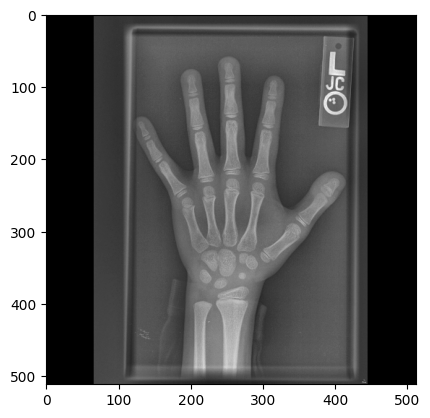

In [165]:

def chargement_images_train_2(numero_patient_train):
    img_path = f'training/{numero_patient_train}.png'
    img = tf.io.read_file(img_path)
    img = tf.image.decode_image(img, channels=3)
    img = tf.image.resize_with_pad(img, 512, 512)
    img = tf.image.rgb_to_grayscale(img)

    def _clahe(img_np):
        img_np = img_np.numpy().astype(np.uint8)  # on convertit en numpy pour appliquer le CLAHE
        clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
        enhanced = clahe.apply(img_np[:, :, 0])         # canal unique (gris)
        return enhanced.astype(np.uint8)

    img = tf.py_function(func=_clahe, inp=[img], Tout=tf.uint8)
    img = tf.cast(img, tf.float32) / 255.0

    return img


def chargement_images_test(numero_patient_train):
    img_path = f'test/{numero_patient_train}.png'
    img = tf.io.read_file(img_path)
    img = tf.image.decode_image(img, channels=3)
    img = tf.image.resize_with_pad(img,512,512) #pad car image rectangulaire paysage et portrait et dim différentes
    img = tf.image.rgb_to_grayscale(img)

    def _clahe(img_np):
        img_np = img_np.numpy().astype(np.uint8)  # on convertit en numpy pour appliquer le CLAHE
        clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
        enhanced = clahe.apply(img_np[:, :, 0])         # canal unique (gris)
        return enhanced.astype(np.uint8)

    img = tf.py_function(func=_clahe, inp=[img], Tout=tf.uint8)
    img = tf.cast(img, tf.float32) / 255.0

    return img 

plt.figure()
plt.imshow(chargement_images_train_2(1700).numpy().squeeze(), cmap='gray')

In [166]:

img_path_k_train = []

for k in numero_patient_train:
    img_path_k_train.append(f'train/{k}.png')
img_path_array = np.array(img_path_k_train)


X_train_images = img_path_array
X_train_sex = np.array([1 if s == True else 0 for s in sexe_train])
y_train = age_osseux_train 


img_path_k_test = []

for k in numero_patient_test:
    img_path_k_test.append(f'test/{k}.png')
img_path_array_test = np.array(img_path_k_test)


X_test_images = img_path_array_test
X_test_sex = np.array([1 if s == True else 0 for s in sexe_test])
y_test = age_osseux_test


Dimension du array contenant les chemins des images de la base d'apprentissage : (300,)
Dimension du array contenant les sexes des pateients :  (300,)
Dimension du array contenant les labels d'age osseux : (300,)
Dimension du array contenant les chemins des images de la base de test : (100,)
Dimension du array contenant les sexes de la base de test : (100,)


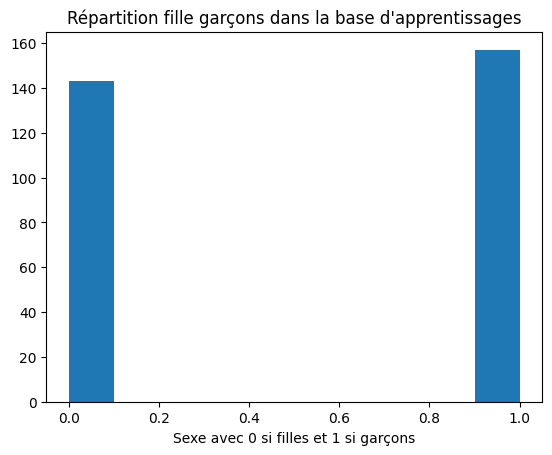

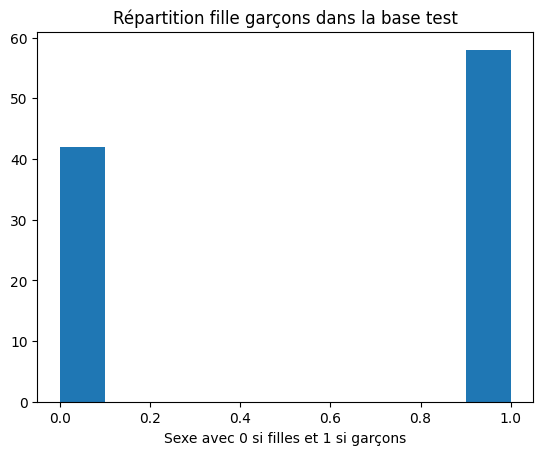

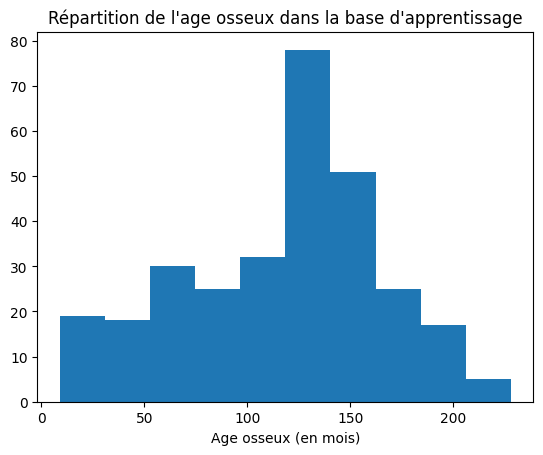

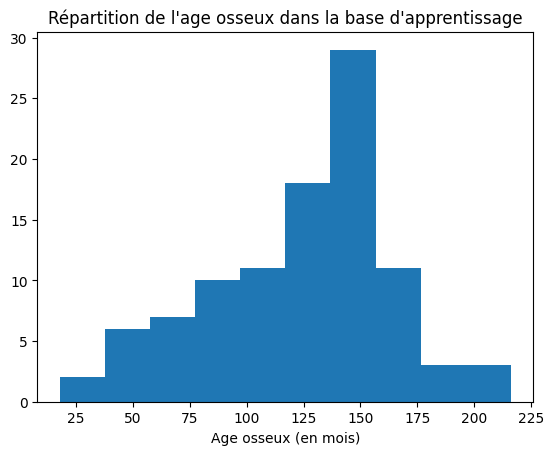

In [ ]:

print("Dimension du array contenant les chemins des images de la base d'apprentissage :",X_train_images.shape)
print("Dimension du array contenant les sexes des pateients : ",X_train_sex.shape)
print("Dimension du array contenant les labels d'age osseux :",y_train.shape)

print("Dimension du array contenant les chemins des images de la base de test :",X_test_images.shape)
print("Dimension du array contenant les sexes de la base de test :",X_test_sex.shape)

plt.figure()
plt.hist(X_train_sex)
plt.title("Répartition fille garçons dans la base d'apprentissages")
plt.xlabel("Sexe avec 0 si filles et 1 si garçons")
plt.show()

plt.figure()
plt.hist(X_test_sex)
plt.title("Répartition fille garçons dans la base test")
plt.xlabel("Sexe avec 0 si filles et 1 si garçons")
plt.show()

plt.figure()
plt.hist(y_train)
plt.title("Répartition de l'age osseux dans la base d'apprentissage")
plt.xlabel("Age osseux (en mois)")
plt.show()

plt.figure()
plt.hist(y_test)
plt.title("Répartition de l'age osseux dans la base d'apprentissage")
plt.xlabel("Age osseux (en mois)")
plt.show()

In [168]:
# Modèle 